In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [118]:
# metadata = pd.read_csv('datasets/top_20_descriptions.csv')
# raw_data = pd.read_csv('datasets/top20_raw.csv')
metadata = pd.read_csv('price_plan_descriptions.csv')
raw_data = pd.read_csv('price_plan.csv')
raw_data['InvoiceDate'] = pd.to_datetime(raw_data['InvoiceDate'], format='%Y-%m-%d')

# Visualize the Relation between Price and Demand

In [122]:
visualization_target = '22616'

/tmp/ipykernel_23652/2898671342.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


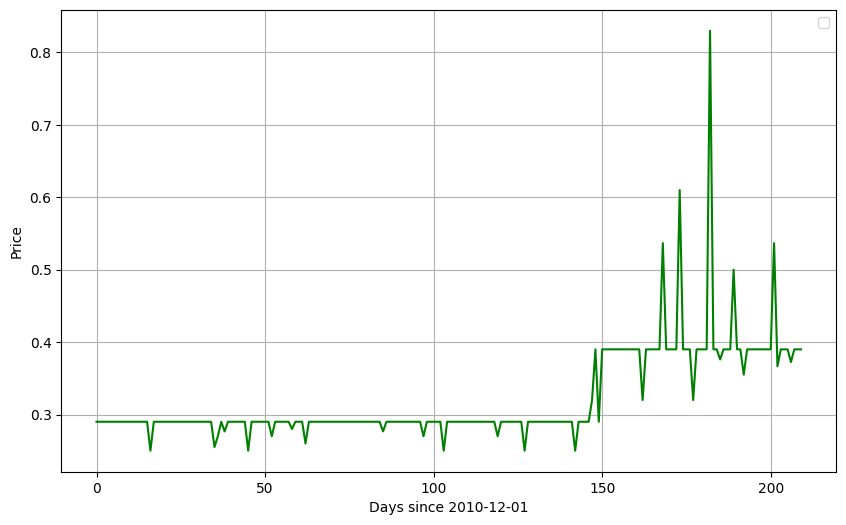

In [123]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(raw_data[raw_data['StockCode'] == visualization_target]['UnitPrice'].to_numpy(), color='green')
plt.xlabel('Days since 2010-12-01')
plt.ylabel('Price')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_23652/839160372.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


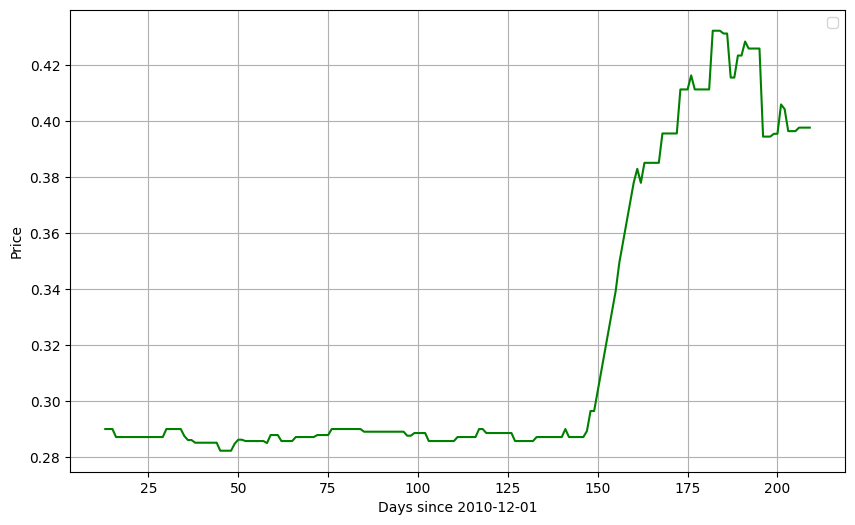

In [124]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(raw_data[raw_data['StockCode'] == visualization_target]['UnitPrice'].rolling(window=14).mean().to_numpy(), color='green')
plt.xlabel('Days since 2010-12-01')
plt.ylabel('Price')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_23652/444585082.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


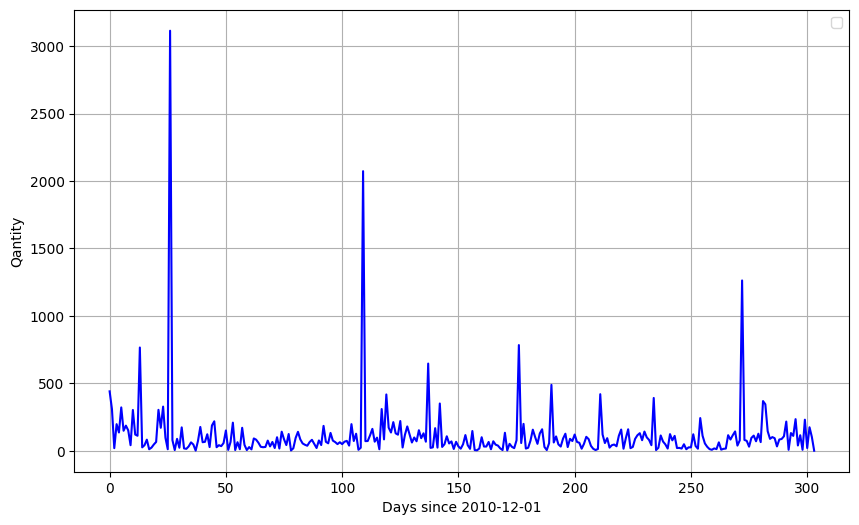

In [ ]:

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(raw_data[raw_data['StockCode'] == visualization_target]['Quantity'].to_numpy(), color='blue')
plt.xlabel('Days since 2010-12-01')
plt.ylabel('Qantity')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_23652/3743691237.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


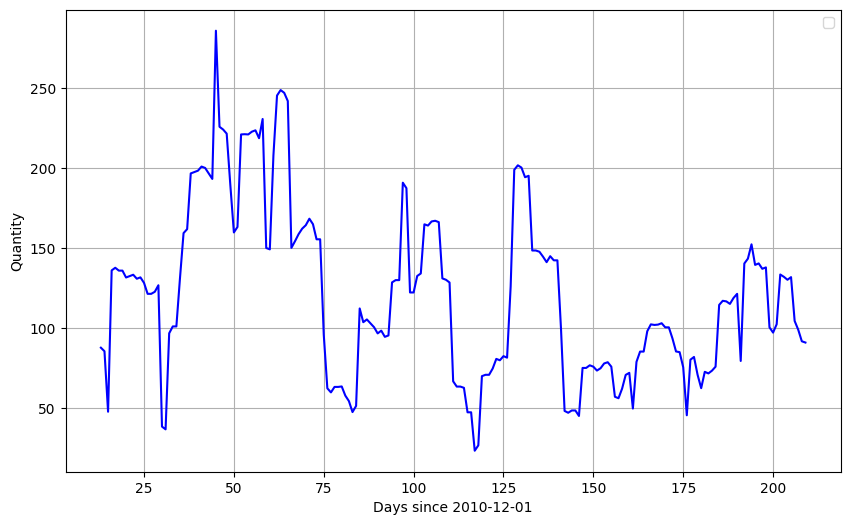

In [125]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(raw_data[raw_data['StockCode'] == visualization_target]['Quantity'].rolling(window=14).mean().to_numpy(), color='blue')
plt.ylabel('Quantity')
plt.xlabel('Days since 2010-12-01')
plt.legend()
plt.grid(True)
plt.show()

# Regression Model

In [4]:
def LR_model_raw(X_train, X_test, y_train, y_test):
    # Create and train the linear regression model with intercept
    model = LinearRegression(fit_intercept=True)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    # mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    return {
        "intercept": model.intercept_,
        "coefficients": model.coef_,
        "r2": r2
    }

In [5]:
def add_Fourier(data: pd.DataFrame) -> pd.DataFrame:
    data['day_of_year'] = data['InvoiceDate'].dt.dayofyear  # Convert date to day index
    # Define Fourier terms (e.g., yearly seasonality with 3 harmonics)
    num_harmonics = 3
    period = 365  # Assuming daily data

    for k in range(1, num_harmonics + 1):
        data[f'sin_{k}'] = np.sin(2 * np.pi * k * data['day_of_year'] / period)
        data[f'cos_{k}'] = np.cos(2 * np.pi * k * data['day_of_year'] / period)

    data.drop(columns=['day_of_year'], inplace=True)  # Remove intermediate column
    return data

In [6]:
pd.options.mode.chained_assignment = None

In [ ]:
def build_model(model_type):
    if model_type == 'LR':
        train_cols = ['LogUnitPrice']
    elif model_type == 'LR_SW':
        train_cols = ['LogUnitPrice', 'price_ma_3w', 'price_std_3w']
    else:
        train_cols = ['LogUnitPrice', 'price_ma_3w', 'price_std_3w', \
                'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3']
    results = []
    models = {}
    target_prodcucts = metadata['StockCode'].unique()
    np.random.seed(42)  # Set random seed for reproducibility
    for stock_code in target_prodcucts:
        print(f"Processing stock code: {stock_code}")
        # continue
        data = raw_data[raw_data['StockCode'] == stock_code][['UnitPrice', 'Quantity', 'InvoiceDate']]
        data.reset_index(drop=True, inplace=True)
        # # smooth the unit price and quantity by rolling mean of 7 days
        data['UnitPrice_14D'] = data['UnitPrice'].rolling(window=14).mean()
        data['Quantity_14D'] = data['Quantity'].rolling(window=14).mean()
        
        # Log transformation on inputs and outputs
        data['LogUnitPrice'] = np.log(data['UnitPrice_14D'].abs().replace(0, np.nan).dropna()) # Apply UnitPrice, UnitPrice-7D or UnitPrice-14D?
        data['LogQuantity'] = np.log(data['Quantity_14D'].abs().replace(0, np.nan).dropna()) # Apply Quantity, Quantity-7D or Quantity-14D?

        # Define sliding window size (e.g., past 3 weeks)
        window_size = 21  # 3 weeks (assuming daily data)
        # Create rolling window features
        data['price_ma_3w'] = data['UnitPrice'].rolling(window=window_size).mean()
        data['price_std_3w'] = data['UnitPrice'].rolling(window=window_size).std()

        # Create Fourier terms for Seaonality
        data = add_Fourier(data)
        
        # Drop rows with NaN values
        data.dropna(inplace=True)
        if data.shape[0] < 10:
            print("No enough data to train or test the model.")
            continue
        # generate a random sequence with a size of len(data) * 0.8
        random_sequence = np.random.choice(len(data), size=int(len(data) * 0.8), replace=False)
        
        # Split the data into training and testing sets
        train_data = data.iloc[random_sequence]
        test_data = data.drop(data.index[random_sequence])
        # only clip outliers in training data
        train_data['LogUnitPrice'] = train_data['LogUnitPrice'].clip(lower=train_data['LogUnitPrice'].quantile(0.05), upper=train_data['LogUnitPrice'].quantile(0.95))
        train_data['LogQuantity'] = train_data['LogQuantity'].clip(lower=train_data['LogQuantity'].quantile(0.05), upper=train_data['LogQuantity'].quantile(0.95))
        X_train = train_data[train_cols].to_numpy() 
        y_train = train_data['LogQuantity'].to_numpy()
        X_test = test_data[train_cols].to_numpy()
        y_test = test_data['LogQuantity'].to_numpy()
        # Train the model
        result = LR_model_raw(X_train, X_test, y_train, y_test)
        if result:
            results.append(f'({stock_code}) {metadata[metadata['StockCode'] == stock_code]['Description'].values[0]}: {result["r2"]}')
            models[stock_code] = {"intercept": result["intercept"], "coefficients": result["coefficients"]}
    return results, models

## Save Results for Model Comparison

In [12]:
import os

In [17]:
results_dir = 'price_plan'

In [25]:
results, _ = build_model('LR')
with open(os.path.join(results_dir, 'price_only_train_outliers.txt'), 'w') as file:
    for result in results:
        file.write(result + '\n')

results, _ = build_model('LR_SW')
with open(os.path.join(results_dir, 'SW_results_price_only_train_outliers.txt'), 'w') as file:
    for result in results:
        file.write(result + '\n')

results, models = build_model('LR_SW_FW')
with open(os.path.join(results_dir, 'SW_results_season_FW_price_only_train_outliers.txt'), 'w') as file:
    for result in results:
        file.write(result + '\n')

Processing stock code: 85123A
Processing stock code: 84879
Processing stock code: 21212
Processing stock code: 21977
Processing stock code: 85099B
Processing stock code: 22197
Processing stock code: 22178
Processing stock code: 22616
Processing stock code: 17003
Processing stock code: 84077
Processing stock code: 85123A
Processing stock code: 84879
Processing stock code: 21212
Processing stock code: 21977
Processing stock code: 85099B
Processing stock code: 22197
Processing stock code: 22178
Processing stock code: 22616
Processing stock code: 17003
Processing stock code: 84077
Processing stock code: 85123A
Processing stock code: 84879
Processing stock code: 21212
Processing stock code: 21977
Processing stock code: 85099B
Processing stock code: 22197
Processing stock code: 22178
Processing stock code: 22616
Processing stock code: 17003
Processing stock code: 84077


In [29]:
# Save the models dictionary to a file
with open(os.path.join(results_dir, 'best_model.pkl'), 'wb') as file:
    pickle.dump(models, file)

In [26]:
from collections import defaultdict
rslt_dict = defaultdict(list)

# Read lines from the text file
with open(os.path.join(results_dir, 'price_only_train_outliers.txt'), 'r') as file:
    lines = file.readlines()

for line in lines:
    rslt = line.replace('\n','').split(' ')
    code = rslt[0]
    value = float(rslt[-1])
    rslt_dict[code].append(value)

# Read lines from the text file
with open(os.path.join(results_dir, 'SW_results_price_only_train_outliers.txt'), 'r') as file:
    lines = file.readlines()
    
# rslt_dict = defaultdict(list)
for line in lines:
    rslt = line.replace('\n','').split(' ')
    code = rslt[0]
    value = float(rslt[-1])
    rslt_dict[code].append(value)

# Read lines from the text file
with open(os.path.join(results_dir, 'SW_results_season_FW_price_only_train_outliers.txt'), 'r') as file:
    lines = file.readlines()
    
# rslt_dict = defaultdict(list)
for line in lines:
    rslt = line.replace('\n','').split(' ')
    code = rslt[0]
    value = float(rslt[-1])
    rslt_dict[code].append(value)

In [27]:
rslt_df = pd.DataFrame.from_dict(rslt_dict, orient='index', columns=['Naive LR', 'LR with Sliding Window', 'LR with Sliding Window and Fourier'])
rslt_df.reset_index(inplace=True)
rslt_df.rename(columns={'index': 'StockCode'}, inplace=True)
rslt_df.head()

,StockCode,Naive LR,LR with Sliding Window,LR with Sliding Window and Fourier
0,(85123A),0.001162,0.037431,0.558526
1,(84879),0.240612,0.231684,0.727365
2,(21212),0.055355,0.049700,0.387713
3,(21977),0.107847,0.118142,0.553030
4,(85099B),0.016097,0.369368,0.694020


In [28]:
rslt_df

,StockCode,Naive LR,LR with Sliding Window,LR with Sliding Window and Fourier
0,(85123A),0.001162,0.037431,0.558526
1,(84879),0.240612,0.231684,0.727365
2,(21212),0.055355,0.049700,0.387713
3,(21977),0.107847,0.118142,0.553030
4,(85099B),0.016097,0.369368,0.694020
5,(22197),-0.026349,0.009496,0.504766
6,(22178),0.009794,0.096383,0.527373
7,(22616),0.026846,0.103378,0.409152
8,(17003),0.177683,0.110809,0.680755
9,(84077),-0.022000,0.258194,0.515907


In [10]:
rslt_df.to_csv('model_comparison.csv', index=False)

# Apply Model to the Next Year

In [30]:
promote_df = pd.read_csv('promote.csv')
promote_df.dropna(inplace=True)
promote_df.rename(columns={'Unnamed: 0': 'StockCode'}, inplace=True)
promote_df.head()

,StockCode,12/1/2011,12/2/2011,12/3/2011,12/5/2011,12/6/2011,12/7/2011,12/8/2011,12/9/2011,12/10/2011,...,3/21/2012,3/22/2012,3/23/2012,3/24/2012,3/26/2012,3/27/2012,3/28/2012,3/29/2012,3/30/2012,3/31/2012
0,85123A,1.61,1.60,1.82,1.84,3.60,1.84,1.86,1.86,1.55,...,161.00,1.87,1.78,1.85,1.77,1.87,1.79,1.86,1.79,1.79
1,84879,0.94,0.86,1.60,0.94,1.63,0.77,0.92,0.89,1.68,...,0.91,0.88,0.92,0.92,0.85,0.94,0.93,0.91,0.75,0.93
2,21212,0.67,0.68,1.88,0.80,0.60,0.84,0.85,0.85,0.78,...,1.84,0.80,0.80,1.80,0.78,0.84,0.84,0.85,0.85,0.83
3,21977,0.64,0.50,1.51,0.68,0.66,1.43,0.69,0.65,0.65,...,0.69,0.68,0.61,0.67,0.63,0.63,0.67,0.61,2.38,0.67
4,85099B,1.25,1.41,3.04,1.40,1.19,1.18,1.39,1.41,3.02,...,2.99,1.46,1.19,1.46,1.40,1.41,1.44,1.40,1.37,1.45


In [31]:
unique_stockcodes = promote_df['StockCode'].unique()
print(unique_stockcodes)

['85123A' '84879' '21212' '21977' '85099B' '22197' '22178' '22616' '17003'
 '84077']


In [32]:
# Melt the dataframe to transform columns into rows#
new_df = promote_df.melt(id_vars=['StockCode'], var_name='InvoiceDate', value_name='UnitPrice')
new_df['InvoiceDate'] = pd.to_datetime(new_df['InvoiceDate'], format='%m/%d/%Y')
new_df.head()

,StockCode,InvoiceDate,UnitPrice
0,85123A,2011-12-01,1.61
1,84879,2011-12-01,0.94
2,21212,2011-12-01,0.67
3,21977,2011-12-01,0.64
4,85099B,2011-12-01,1.25


In [33]:
raw_data = pd.concat([raw_data[['StockCode', 'InvoiceDate', 'UnitPrice', 'Quantity']], new_df], ignore_index=True)
raw_data.head()

,StockCode,InvoiceDate,UnitPrice,Quantity
0,17003,2010-12-01,0.210,36.0
1,17003,2010-12-02,0.210,36.0
2,17003,2010-12-05,0.185,723.0
3,17003,2010-12-06,0.210,180.0
4,17003,2010-12-09,0.210,36.0


In [48]:
with open(os.path.join(results_dir, 'best_model.pkl'), 'rb') as file:
    loaded_models = pickle.load(file)

In [35]:
coefficents = {k: v['coefficients'][0] for k, v in loaded_models.items()}

In [36]:
coefficents

{'85123A': np.float64(-1.8590686294847447),
 '84879': np.float64(-71.25729875272307),
 '21212': np.float64(-9.90639400955296),
 '21977': np.float64(-9.632300875732692),
 '85099B': np.float64(-28.314934627526206),
 '22197': np.float64(-26.025802351034816),
 '22178': np.float64(-6.725714207311105),
 '22616': np.float64(-3.920908662876134),
 '17003': np.float64(-4.127348092214127),
 '84077': np.float64(-4.103066068928438)}

In [37]:
elasticity_df = pd.DataFrame(list(coefficents.items()), columns=['StockCode', 'Elasticity'])
elasticity_df.head()

,StockCode,Elasticity
0,85123A,-1.859069
1,84879,-71.257299
2,21212,-9.906394
3,21977,-9.632301
4,85099B,-28.314935


In [38]:
elasticity_df.to_csv('elasticity.csv', index=False)

In [82]:
results = {}
target_prodcucts = promote_df['StockCode'].unique()
inputs_dict = {}
for stock_code in target_prodcucts:
    print(f"Processing stock code: {stock_code}")
    if stock_code not in loaded_models:
        print(f"Model for stock code {stock_code} not found.")
        continue
    model_params = loaded_models[stock_code]
    model = LinearRegression()
    model.intercept_ = model_params['intercept']
    model.coef_ = model_params['coefficients']

    # Prepare the data for prediction
    data = raw_data[(raw_data['StockCode'] == stock_code) & (raw_data['InvoiceDate'] >= pd.to_datetime('2011-12-01'))][['UnitPrice', 'Quantity', 'InvoiceDate']]
    data['UnitPrice_14D'] = data['UnitPrice'].rolling(window=14).mean()
    # data.dropna(subset=['UnitPrice_14D'], inplace=True)
    data['LogUnitPrice'] = np.log(data['UnitPrice_14D'].abs().replace(0, np.nan).dropna())

    # Define sliding window size (e.g., past 3 weeks)
    window_size = 21  # 3 weeks (assuming daily data)
    # Create rolling window features
    data['price_ma_3w'] = data['UnitPrice'].rolling(window=window_size).mean()
    data['price_std_3w'] = data['UnitPrice'].rolling(window=window_size).std()
    # Create Fourier terms for Seaonality
    data = add_Fourier(data)

    inputs = data[['LogUnitPrice', 'price_ma_3w', 'price_std_3w', \
                               'sin_1', 'cos_1', 'sin_2', 'cos_2', 'sin_3', 'cos_3']].dropna().to_numpy()
    # Make predictions
    y_pred = model.predict(inputs)
    # # reverse log transformation on predicted values
    # y_pred = np.exp(y_pred)
    results[stock_code] = y_pred
    inputs_dict[stock_code] = inputs

    

Processing stock code: 85123A
Processing stock code: 84879
Processing stock code: 21212
Processing stock code: 21977
Processing stock code: 85099B
Processing stock code: 22197
Processing stock code: 22178
Processing stock code: 22616
Processing stock code: 17003
Processing stock code: 84077


In [128]:
target_product = '17003'

/tmp/ipykernel_23652/3041899796.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


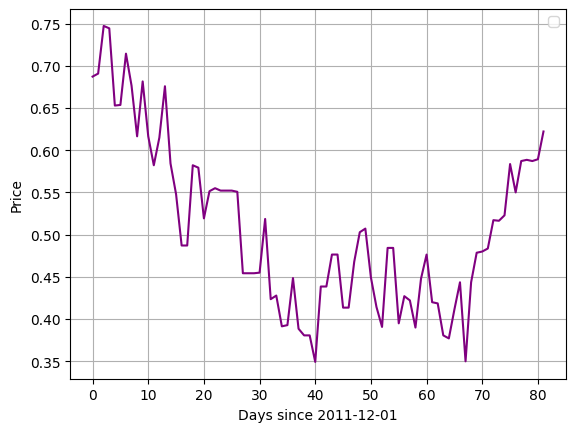

In [100]:
plt.plot(np.exp(inputs_dict[target_product][:, 0]), color='purple')
plt.xlabel('Days since 2011-12-01')
plt.ylabel('Price')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_23652/67267331.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


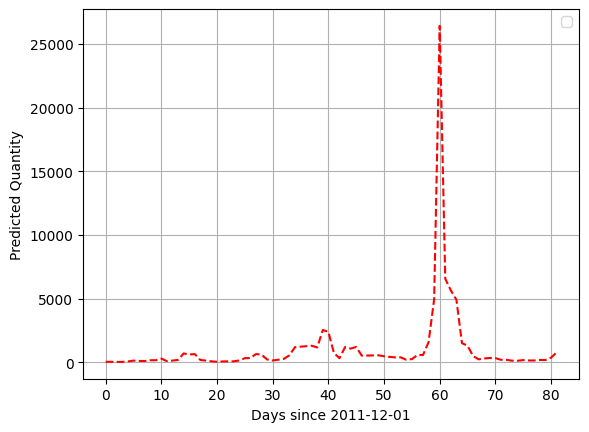

In [129]:
plt.plot(np.exp(results[target_product]), color='red', linestyle='--')
plt.xlabel('Days since 2011-12-01')
plt.ylabel('Predicted Quantity')
# plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# # Plot actual vs predicted values
# # plt.figure(figsize=(10, 6))
# tmp = raw_data[(raw_data['StockCode'] == target_product) & \
#                (raw_data['InvoiceDate'] >= pd.to_datetime('2011-11-01'))]
# tmp['UnitPrice_14D'] = tmp['UnitPrice'].rolling(window=14).mean().replace(0, np.nan).dropna()

# plt.plot(tmp['UnitPrice_14D'].to_numpy(), color='purple')
# plt.xlabel('Time')
# plt.ylabel('Price')
# # plt.title('Actual vs Predicted Values')
# plt.legend()
# plt.grid(True)
# plt.show()

In [ ]:
# prev = raw_data[(raw_data['StockCode'] == target_product) & \
#                (raw_data['InvoiceDate'] >= pd.to_datetime('2011-11-01')) &\
#                 (raw_data['InvoiceDate'] < pd.to_datetime('2011-12-01'))]
# vis = np.concatenate((prev['Quantity'].rolling(window=14).mean().to_numpy(), np.exp(results[target_product])))

# plt.figure(figsize=(10, 6))
# plt.plot(vis, color='red', linestyle='--')
# plt.xlabel('Days since 2011-11-01')
# plt.ylabel('Predicted Quantity')
# # plt.title('Actual vs Predicted Values')
# plt.legend()
# plt.grid(True)
# plt.show()